In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import corner
import scipy.stats as st
from statistics import mean
from collections import Counter

In [ ]:
file_path = 'Datasets/mt_genes_metadata.csv'

met = pd.read_csv(file_path)

pro_code=met[met['gene_type']=='protein_coding']
intpro=pro_code['gene_name'].tolist()
intpro=['MT-ND1','MT-ND2','MT-ND3','MT-ND4','MT-ND4L','MT-ND5','MT-ND6', 'MT-CO1', 'MT-CO2','MT-CO3', 'MT-ATP6', 'MT-ATP8', 'MT-CYB']
intpro

In [ ]:
file_path = 'Datasets/Donor1_CD4_Genes.csv'

p14 = pd.read_csv(file_path)

p14.drop(columns=p14.columns[0], axis=1, inplace=True)

pat1_4int=pd.DataFrame([p14[i] for i in intpro]).T

file_path = 'Datasets/Donor1_CD8_Genes.csv'

p18 = pd.read_csv(file_path)

p18.drop(columns=p18.columns[0], axis=1, inplace=True)

pat1_8int=pd.DataFrame([p18[i] for i in intpro]).T

file_path = 'Datasets/Donor2_CD4_Genes.csv'

p24 = pd.read_csv(file_path)

p24.drop(columns=p24.columns[0], axis=1, inplace=True)

pat2_4int=pd.DataFrame([p24[i] for i in intpro]).T

file_path = 'Datasets/Donor2_CD8_Genes.csv'

p28 = pd.read_csv(file_path)

p28.drop(columns=p28.columns[0], axis=1, inplace=True)

pat2_8int=pd.DataFrame([p28[i] for i in intpro]).T

total=pd.concat([p14,p18,p24,p28])

total_int=pd.concat([pat1_4int,pat1_8int, pat2_4int,pat2_8int])

totaln=len(total_int)


In [ ]:
total_sampto=total.sum() #total number of each gene
totalgene=total_sampto.sum() #total number of genes

In [ ]:
#number of DNA strands in each file
p14n=len(pat1_4int)
p18n=len(pat1_8int)
p24n=len(pat2_4int)
p28n=len(pat2_8int)

In [ ]:
#Calculates the number of genes for each DNA
p14_allsampto=p14.sum(axis=1)
p18_allsampto=p18.sum(axis=1)
p24_allsampto=p24.sum(axis=1)
p28_allsampto=p28.sum(axis=1)

Normalising data and then computing Unbiased estimate of neg binom proportion

Plotting the histograms of the UEM to estimate a prior for the UEM for posterior checks.

In [ ]:
r=1000
uem14_list=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p14n):   
        norm_cons=(p14_allsampto[i]-p14[j][i])/r #inidividual normalisation constant
        x=p14[j][i]/norm_cons
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem14_list.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem14_list=dict(zip(intpro,uem14_list))

uem18_list=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p18n):   
        norm_cons=(p18_allsampto[i]-p18[j][i])/r #inidividual normalisation constant
        x=p18[j][i]/norm_cons
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_8'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
    uem18_list.append(mean(uem_sample_list))
uem18_list=dict(zip(intpro,uem18_list))

uem24_list=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p24n):   
        norm_cons=(p24_allsampto[i]-p24[j][i])/r #inidividual normalisation constant
        x=p24[j][i]/norm_cons
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem24_list.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat2_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem24_list=dict(zip(intpro,uem24_list))

uem28_list=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p28n):   
        norm_cons=(p28_allsampto[i]-p28[j][i])/r #inidividual normalisation constant
        x=p28[j][i]/norm_cons
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem28_list.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat2_8'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem28_list=dict(zip(intpro,uem28_list))
uem28_list

χ² test: H0: Follows nbin, H1: Doesn't Follow

In [ ]:
#p1_4
df14=p14n-1
cv=st.chi2.ppf(0.99,df14)
chi1_p14_ts=[]
chi1_p14_res=[]
for j in intpro:
    ts=0
    p=uem14_list[j]
    for i in range(p14n):
        r=1000
        norm_cons=(p14_allsampto[i]-p14[j][i])/r #inidividual normalisation constant
        o=p14[j][i]/norm_cons
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi1_p14_ts.append(ts)
    chi1_p14_res.append(ts-cv)
chi_p14_res=dict(zip(intpro,chi1_p14_res))
chi_p14_res

In [ ]:
#p1_8
df18=p18n-1
cv=st.chi2.ppf(0.99,df18)
chi1_p18_ts=[]
chi1_p18_res=[]
for j in intpro:
    ts=0
    p=uem18_list[j]
    for i in range(p18n):
        r=1000
        norm_cons=(p18_allsampto[i]-p18[j][i])/r #inidividual normalisation constant
        o=p18[j][i]/norm_cons
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi1_p18_ts.append(ts)
    chi1_p18_res.append(ts-cv)
chi_p18_res=dict(zip(intpro,chi1_p18_res))
chi_p18_res

In [ ]:
#p2_4
df24=p24n-1
cv=st.chi2.ppf(0.99,df24)
chi1_p24_ts=[]
chi1_p24_res=[]
for j in intpro:
    ts=0
    p=uem24_list[j]
    for i in range(p24n):
        r=1000
        norm_cons=(p24_allsampto[i]-p24[j][i])/r #inidividual normalisation constant
        o=p24[j][i]/norm_cons
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi1_p24_ts.append(ts)
    chi1_p24_res.append(ts-cv)
chi_p24_res=dict(zip(intpro,chi1_p24_res))
chi_p24_res

In [ ]:
#p2_8
df28=p28n-1
cv=st.chi2.ppf(0.99,df28)
chi1_p28_ts=[]
chi1_p28_res=[]
for j in intpro:
    ts=0
    p=uem28_list[j]
    for i in range(p28n):
        r=1000
        norm_cons=(p28_allsampto[i]-p28[j][i])/r #inidividual normalisation constant
        o=p28[j][i]/norm_cons
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi1_p28_ts.append(ts)
    chi1_p28_res.append(ts-cv)
chi_p28_res=dict(zip(intpro,chi1_p28_res))
chi_p28_res

In [ ]:
chi_p14_resdf=pd.Series(chi_p14_res)
chi_p14_resdf=pd.DataFrame(chi_p14_resdf,columns=['P1_4'])
chi_p18_resdf=pd.Series(chi_p18_res)
chi_p18_resdf=pd.DataFrame(chi_p18_resdf,columns=['P1_8'])
chi_p24_resdf=pd.Series(chi_p24_res)
chi_p24_resdf=pd.DataFrame(chi_p24_resdf,columns=['P2_4'])
chi_p28_resdf=pd.Series(chi_p28_res)
chi_p28_resdf=pd.DataFrame(chi_p28_resdf,columns=['P2_8'])
overall_chi_res=pd.concat([chi_p14_resdf,chi_p18_resdf,chi_p24_resdf, chi_p28_resdf], axis=1)

In [ ]:
overall_chi_res

The following started with trying a Partial correlation analysis by plotting each gene against 'non-MT' UMI. but the rvalues were rather low.

Instead, I experimented a bit and plotted the y against √xy where y=interested gene, x='non-MT'

In [ ]:
x=p14['non-MT']
r14_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p14[i]
    ax.set_title('p14'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r14_l.append(lin.rvalue)
    plt.show()
r14_l


In [ ]:
x=p18['non-MT']
r18_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p18[i]
    ax.set_title('p18'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r18_l.append(lin.rvalue)
    plt.show()
r18_l


In [ ]:
x=p24['non-MT']
r24_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p24[i]
    ax.set_title('p24'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r24_l.append(lin.rvalue)
    plt.show()
r24_l


In [ ]:
x=p28['non-MT']
r28_l=[] #rvalues
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p28[i]
    ax.set_title('p28'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r28_l.append(lin.rvalue)
    plt.show()
r28_l


In [ ]:
x=p14['non-MT']
resi14=pd.DataFrame()
i='MT-ND1'
fig, ax = plt.subplots(1, 1) 
y=p14[i]
lin_x=x
lin_y=y
lin=st.linregress(lin_x,lin_y)
fit=lin.intercept+lin.slope*lin_x
resdf=pd.DataFrame(lin_y-fit)
resdf.columns=[i]
resi14=resi14.join(resdf,how='outer')
ax.set_title('p14'+i)
ax.scatter(lin_x,lin_y)
ax.plot(lin_x,fit, color='red',label=lin.rvalue)
plt.legend()
plt.show()
resi14

Calculating the residuals as part of the analysis (and also plotting to check residuals)

In [ ]:
x=p14['non-MT']
resi14=pd.DataFrame()
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p14[i]
    lin_x=x
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resdf=pd.DataFrame(lin_y-fit)
    resdf.columns=[i]
    resi14=resi14.join(resdf,how='outer')
    ax.scatter(lin_x,lin_y)
    ax.plot(lin_x,fit, color='red',label=lin.rvalue)
    ax.set_title('p14'+i)
    plt.legend()
    plt.show()
resi14

Following are the plots of the (untransformed) residuals against another, with the linear regression plotted and corresponding r-value 

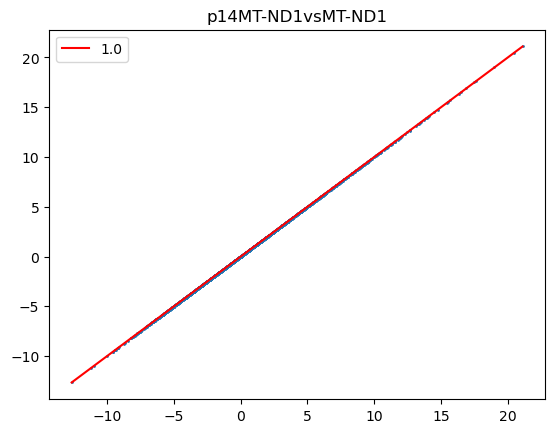

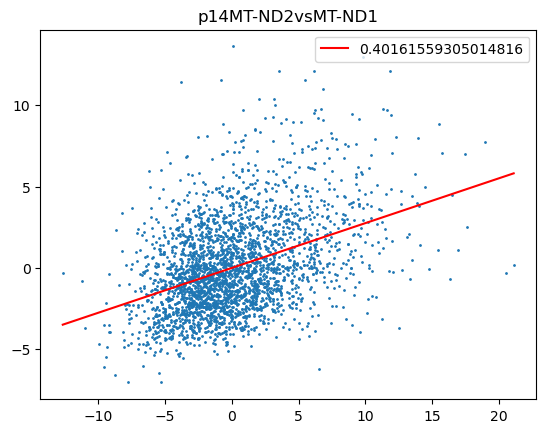

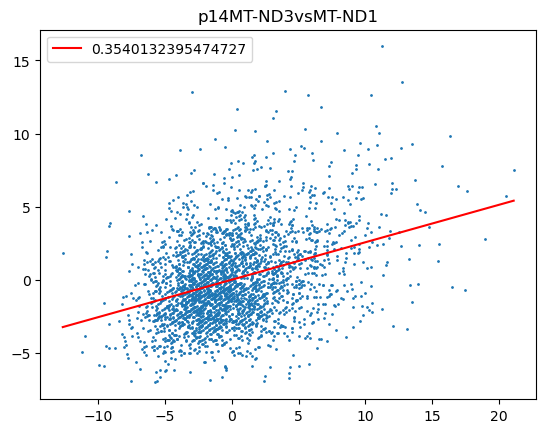

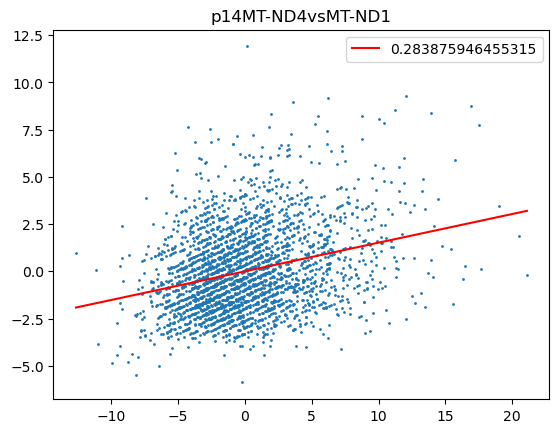

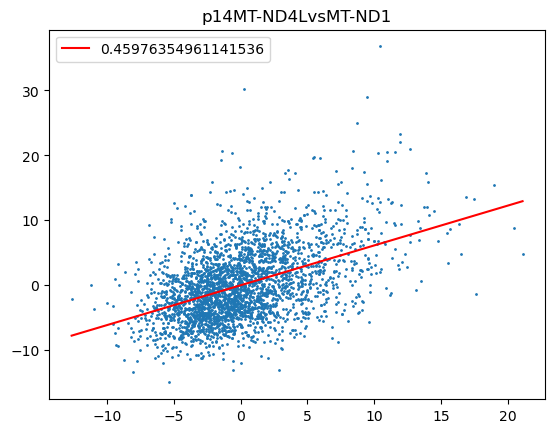

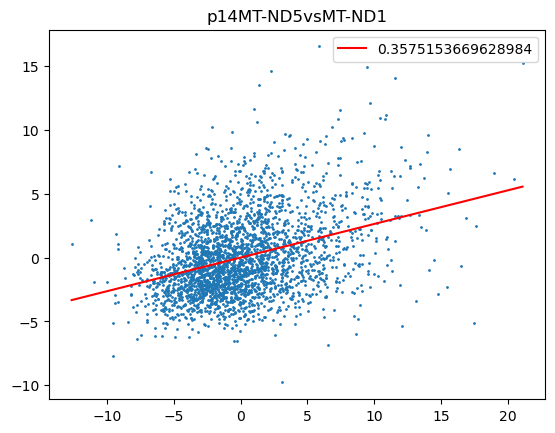

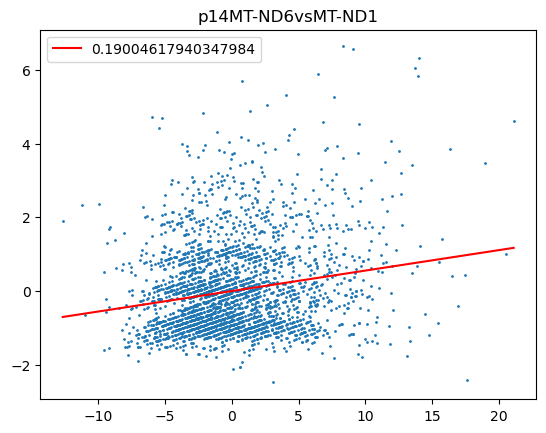

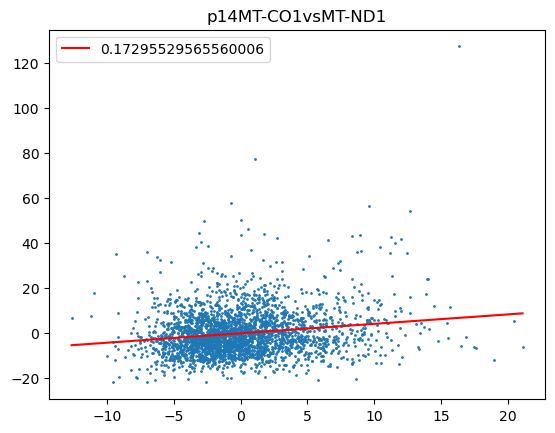

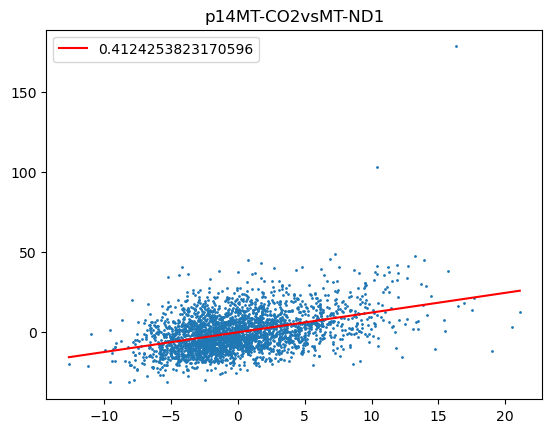

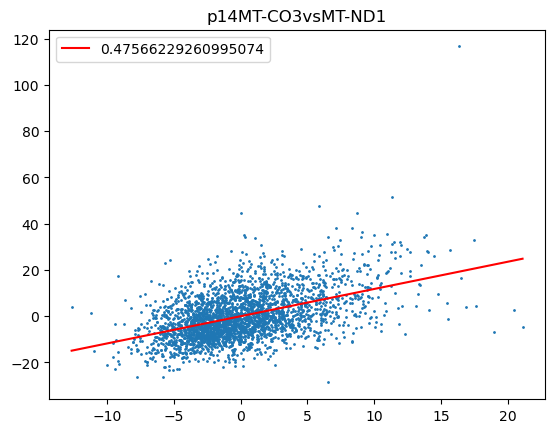

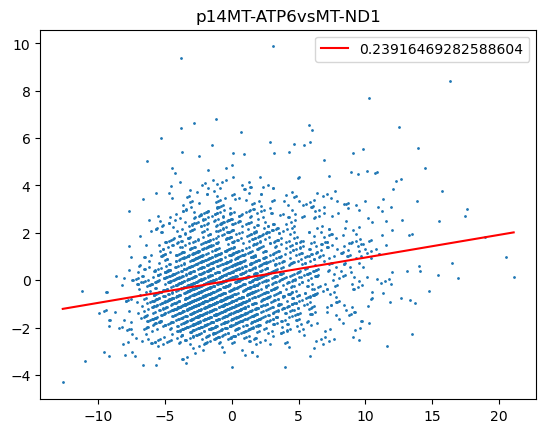

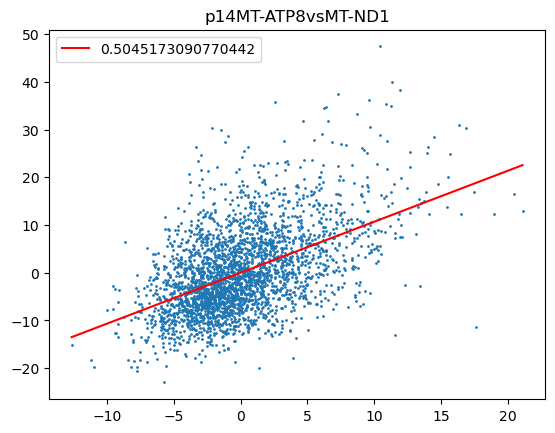

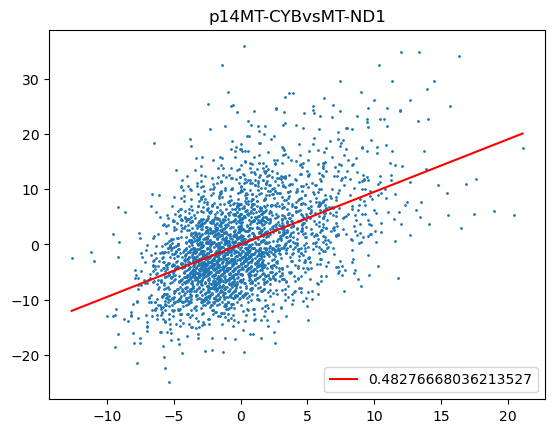

In [144]:
tet=[]
j='MT-ND1'
res_x=resi14[j]
res_col=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'vs'+j)
    lin_x=res_x
    lin_y=res_y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()

In [ ]:
res_x=resi14['MT-ND1']
res_y=resi14['MT-ND2']
lin_x=np.sqrt(np.abs((res_x*res_y)**2/(0.01)**2-1))
lin_y=np.abs(res_y)


In [147]:
from statistics import stdev
res14_D2_sd=stdev(resi14['MT-ND2'])

Checkpoint: 060624

To do next: Normalise the residuals somehow (the one where you log, refer to checkpoint

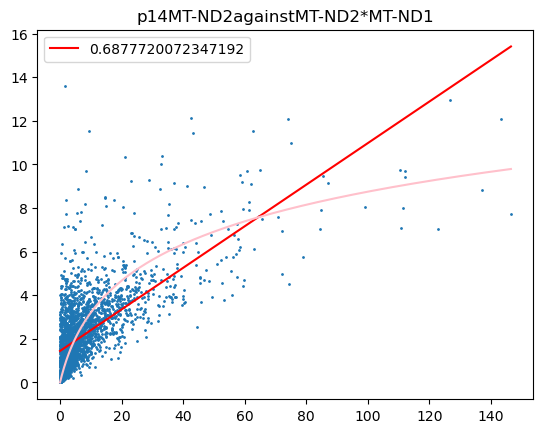

In [153]:
#plotting |y| against ln(|xy|/k+1)
j='MT-ND1'
res_x=resi14[j]
i='MT-ND2'
fig, ax = plt.subplots(1, 1) 
res_y=resi14[i]
ax.set_title('p14'+i+'against'+i+'*'+j)
lin_x=np.abs(res_x*res_y)
lin_y=np.abs(res_y)
ax.scatter(lin_x,lin_y, s=1)
M=max(lin_x)
m=min(lin_x)
lin=st.linregress(lin_x,lin_y)
l=np.array([m,M])
ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
hyp_x=np.linspace(m,M,1000)
hyp_y=np.log(hyp_x/(res14_D2_sd**1.5)+1)
ax.plot(hyp_x,hyp_y*res14_D2_sd,color='pink')
plt.legend()
plt.show()

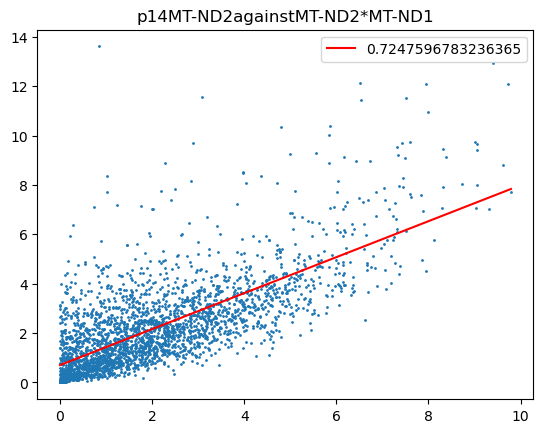

In [154]:
#plotting |y| against |xy|
j='MT-ND1'
res_x=resi14[j]
i='MT-ND2'
fig, ax = plt.subplots(1, 1) 
res_y=resi14[i]
ax.set_title('p14'+i+'against'+i+'*'+j)
lin_x1=np.abs(res_x*res_y)
lin_y=np.abs(res_y)
lin_x=np.log(lin_x1/(res14_D2_sd**1.5)+1)*res14_D2_sd
ax.scatter(lin_x,lin_y, s=1)
M=max(lin_x)
m=min(lin_x)
lin=st.linregress(lin_x,lin_y)
l=np.array([m,M])
ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
plt.legend()
plt.show()

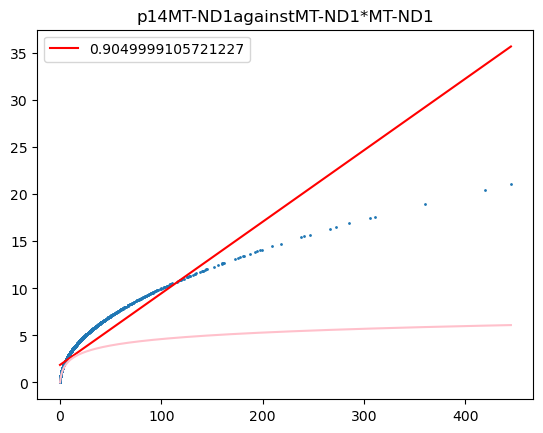

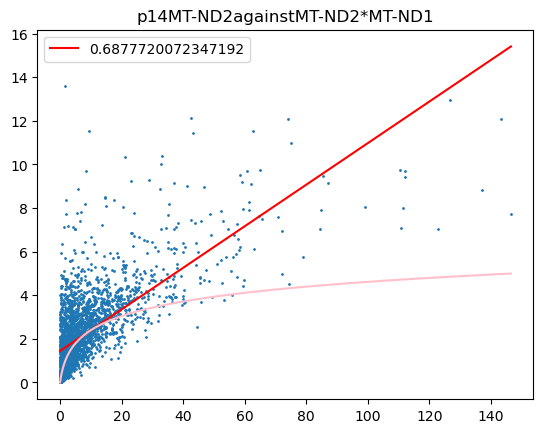

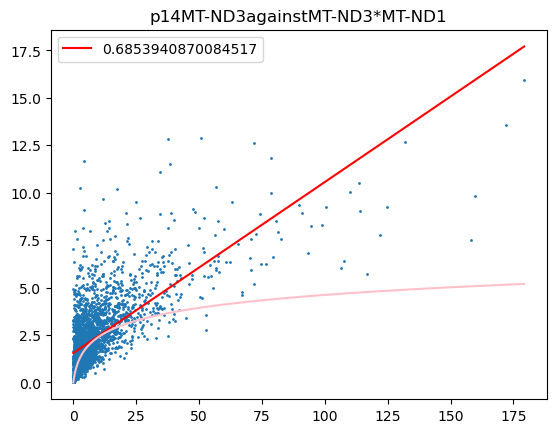

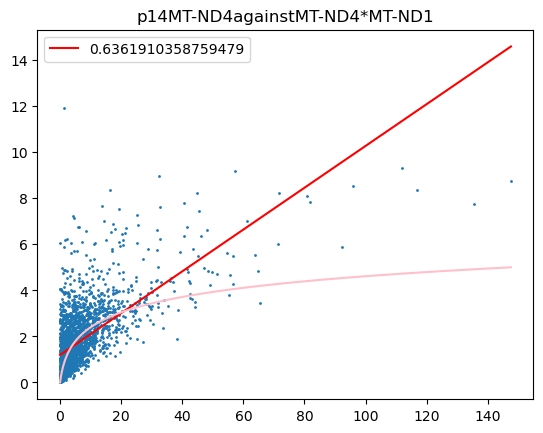

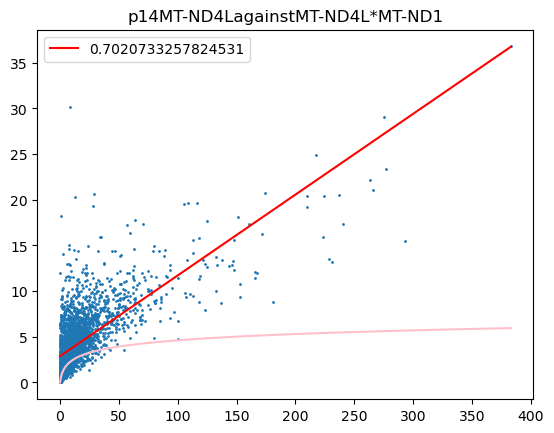

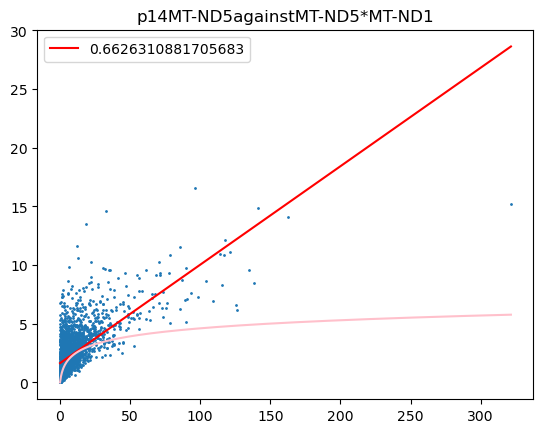

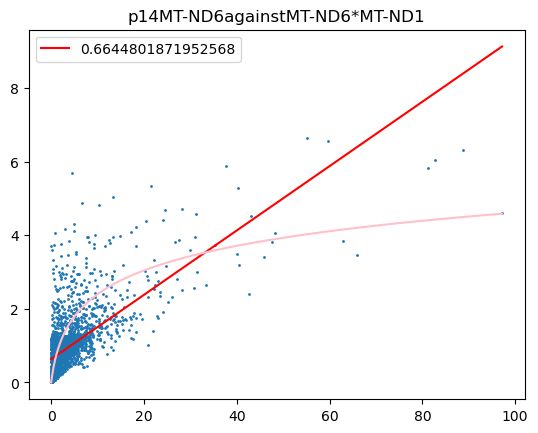

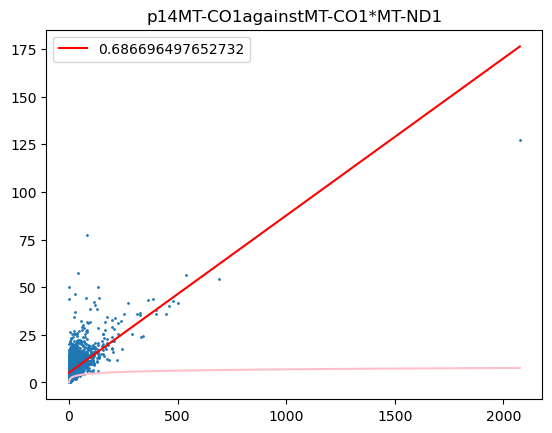

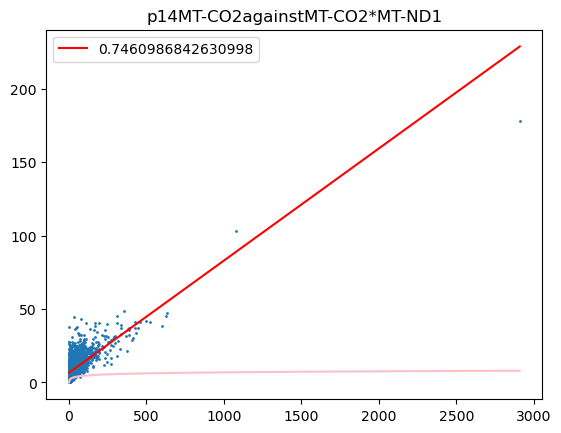

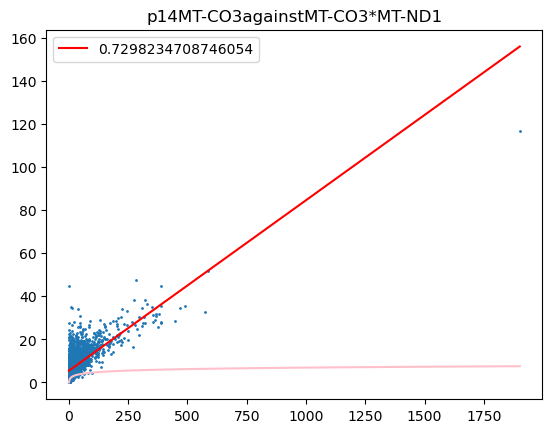

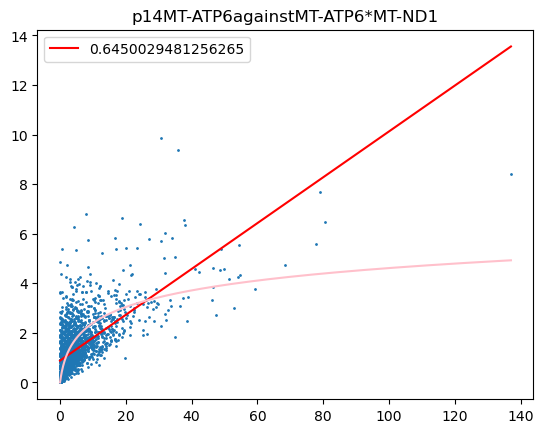

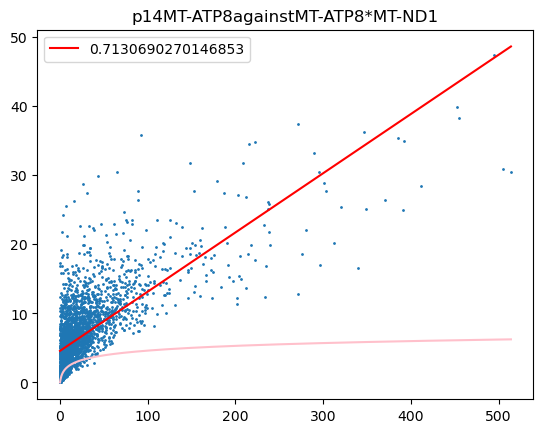

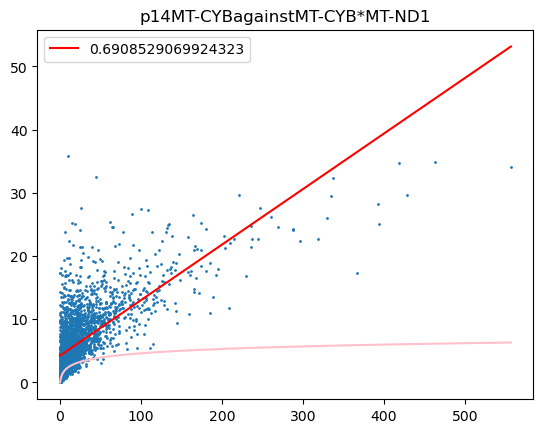

In [143]:
#plotting |y| against |xy|
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    lin_x=np.abs(res_x*res_y)
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    hyp_x=np.linspace(m,M,1000)
    hyp_y=np.log(hyp_x+1)
    ax.plot(hyp_x,hyp_y,color='pink')
    plt.legend()
    plt.show()

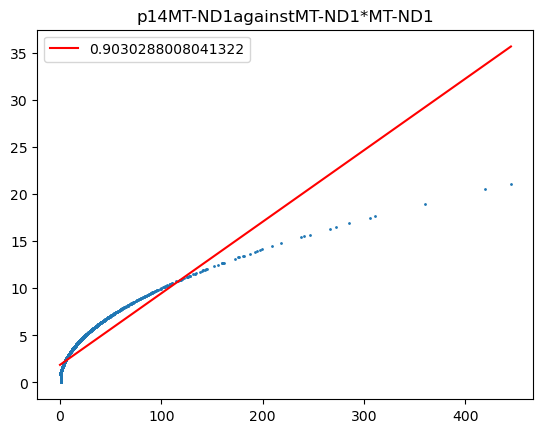

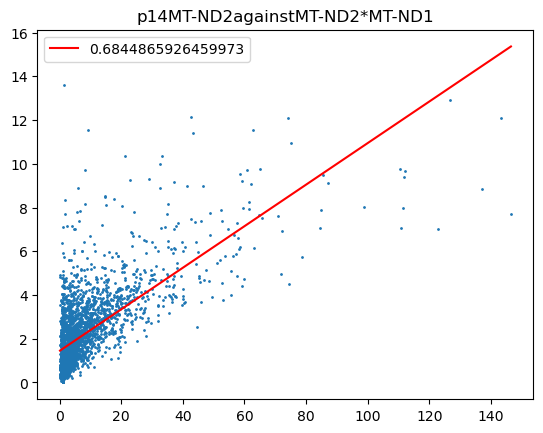

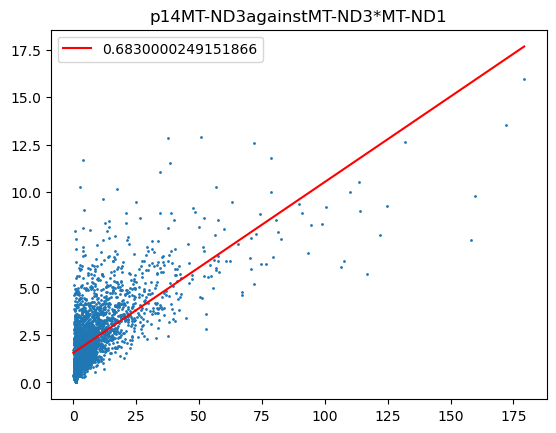

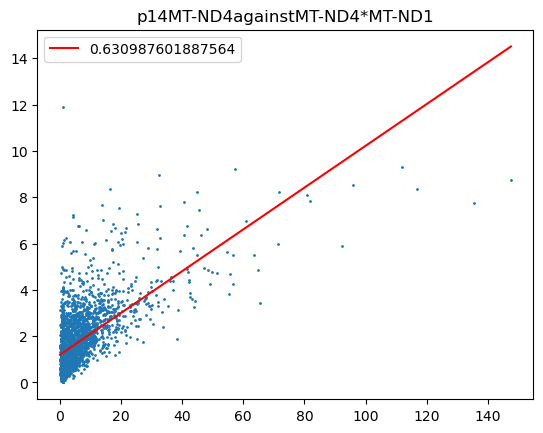

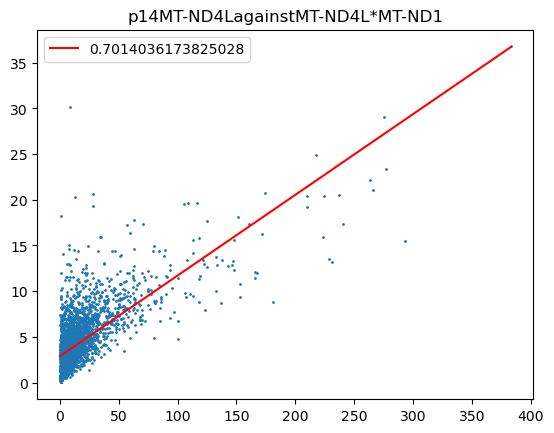

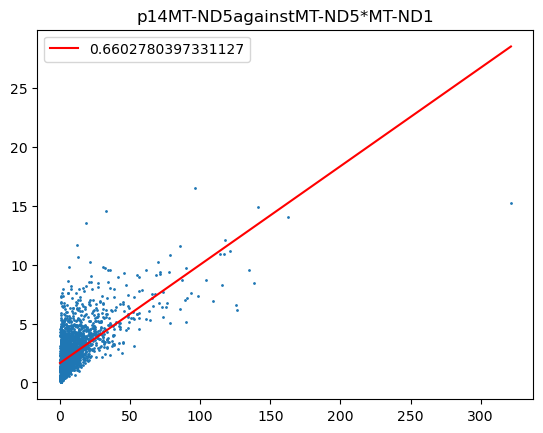

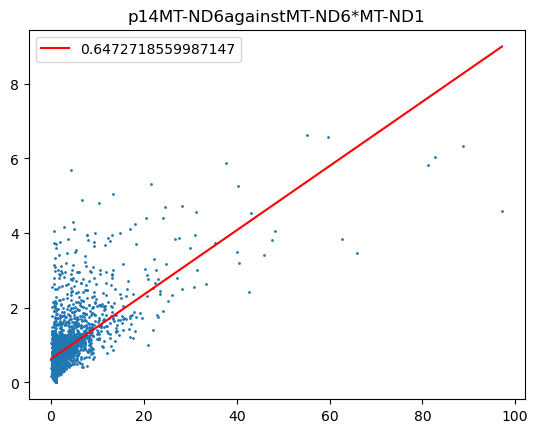

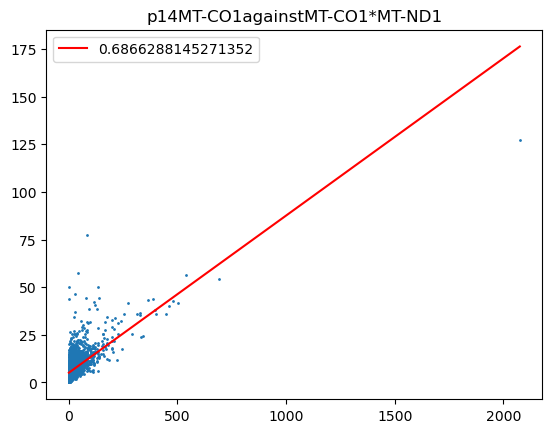

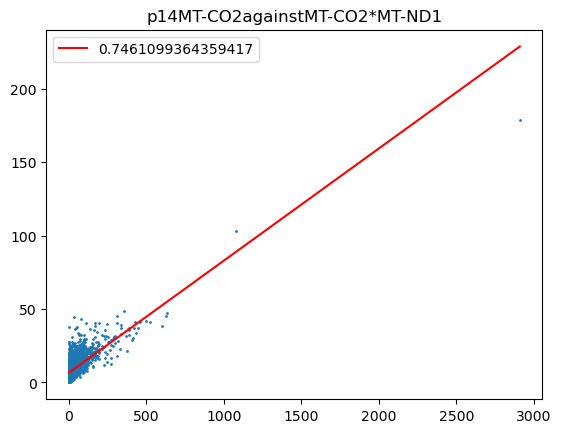

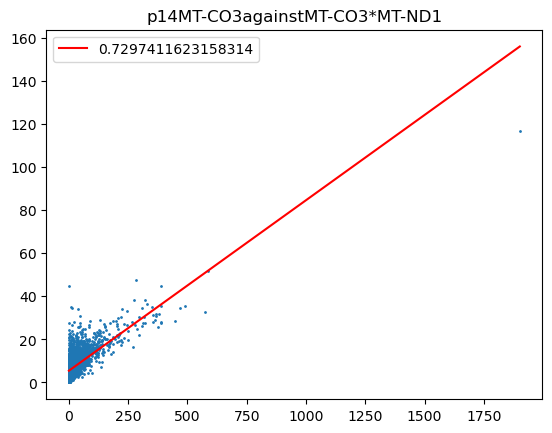

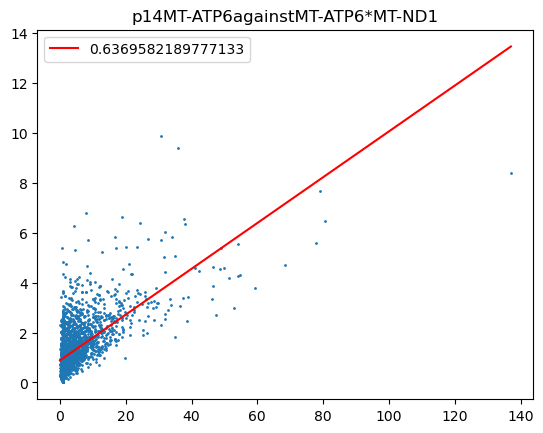

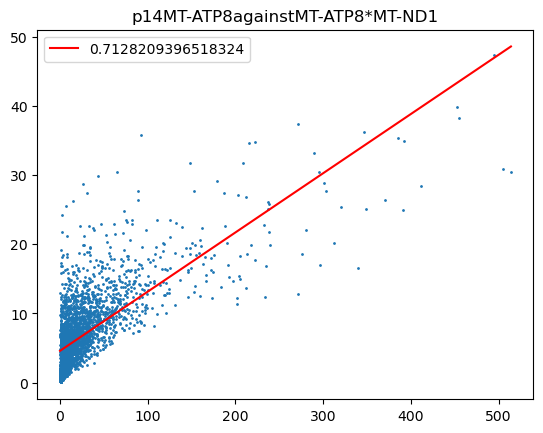

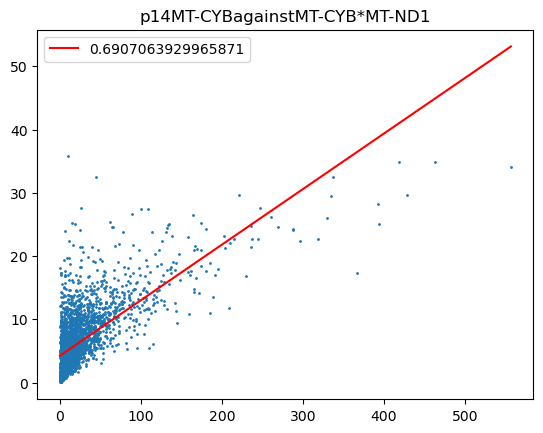

In [119]:
#plotting |y| against √|xy^2/k-1|
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    lin_x=
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()


In [ ]:
#plotting |y| against √|xy|
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    lin_x=np.sqrt(np.abs(res_x*res_y))
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()


In [ ]:
#plotting |y| against sigmoid(|xy|)
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    trans_x=np.abs(res_x*res_y)
    lin_x=
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()

Residuals plot: y against x*y

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        res_y=resi14[i]
        ax.set_title('p14'+i+'against'+i+'*'+j)
        lin_x=res_x*res_y
        lin_y=res_y
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
        res_col.append(lin.rvalue)
        plt.legend()
        plt.show()
    r_resi14_l.append(res_col)  

Plotting residuals: y against |xy|

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        res_y=resi14[i]
        ax.set_title('p14'+i+'against'+i+'*'+j)
        lin_x=res_x
        lin_y=np.abs(res_y*res_x)
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
        res_col.append(lin.rvalue)
        plt.legend()
        plt.show()
    r_resi14_l.append(res_col)  

In [ ]:
resi18=pd.DataFrame()
x=p18['non-MT']
for i in intpro:
    y=p18[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi18=resi18.join(pd.DataFrame(lin_y-fit), how='outer')
resi18

In [ ]:
resi14['MT-ND1']

In [ ]:
#function to calc and include r-value onto the plots
def rval(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = st.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [ ]:
res_plot=sns.pairplot(resi14,kind='reg', diag_kind='kde',plot_kws={'line_kws':{'color':'red'}},corner=True)
res_plot.map_lower(rval)
plt.show()

rvalue looks very bleak...
Transforming the residuals to a similar way to above

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        y=resi14[i]
        ax.set_title('p14'+j+'against'+'sqrt'+'('+i+j+')')
        lin_x=x*y
        lin_y=y
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red')
        res_col.append(lin.rvalue)
        plt.show()
    r_resi14_l.append(res_col)  

In [ ]:
tex=resi14['MT-ND1']*resi14['MT-ND2']
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Log?

In [ ]:
tex=np.log(resi14['MT-ND1']*resi14['MT-ND2']+4)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Hyperbola idea but instead, consider reciprocal function and take negative, then translate upwards. 

i.e: -β_1 (xy-k)**(-n) + β_0

In [ ]:
tex=-1/(resi14['MT-ND1']*resi14['MT-ND2']+0.1)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Below are a few code trying to fit a hyperbola (incomplete)

In [ ]:
np.sqrt((resi14['MT-ND1']*resi14['MT-ND2']+1)**2/0.05-1)

In [ ]:
tex=np.sqrt((resi14['MT-ND1']*resi14['MT-ND2'])**2/0.05-1)
np.isnan(tex).any()

In [ ]:
tex=np.sqrt((resi14['MT-ND1']*resi14['MT-ND2']+2)**2-0.25)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

In [ ]:
tex=np.sqrt(resi14['MT-ND1']*resi14['MT-ND2'])
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()

In [ ]:
m_tex=abs(min(resi14['MT-ND1']*resi14['MT-ND2']))
tex=np.sqrt(resi14['MT-ND1']*resi14['MT-ND2']+m_tex)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Code to plot the transformed residuals (incomplete)

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        res_y=resi14[i]
        ax.set_title('p14'+j+'against'+'sqrt'+'('+i+j+')')
        lin_x=np.sqrt(res_x*res_y)
        lin_y=res_y
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red')
        res_col.append(lin.rvalue)
        plt.show()
    r_resi14_l.append(res_col)  

In [ ]:
r_resi14_l

In [ ]:
resi24=pd.DataFrame()
for i in intpro:
    y=p24[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi24=resi24.join(pd.DataFrame(lin_y-fit), how='outer')
resi24

In [ ]:
resi28=pd.DataFrame()
for i in intpro:
    y=p28[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi28=resi28.join(pd.DataFrame(lin_y-fit), how='outer')
resi28

In [ ]:
x=p28['non-MT']
p28_resi=[]
for i in intpro:
    y=p28[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi=lin_y-fit
p28_resi

For justification: The following was the original plan: plotting gene against non-MT UMI.

Terrible r-value

In [ ]:
r_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+i)
    ax.scatter(p14['non-MT'],p14[i],s=1)
    beta=st.linregress(p14['non-MT'], p14[i])
    ax.plot(np.linspace(0,20000,num=5),beta.slope*np.linspace(0,20000,num=5)+beta.intercept,color='red')
    r_l.append(beta.rvalue)
    plt.show()


In [ ]:
r_l